- CNN pour la clacification du dataset avec les 10 catégorie https://keras.io/api/datasets/cifar10/
#- Fine tuning de mobilenet (ajout d'un dense layer pour catégorisation)

## Step 0: Mac M2 GPU

- The Neural Engine is primarily used for inference through Core ML
- TensorFlow training uses the GPU cores via Metal Performance Shaders (MPS)
- As of 2024, use Python 3.11 with TensorFlow 2.15.1 and tensorflow-metal 1.1.0 for best compatibility

In [56]:
%pip install tensorflow-metal
%pip install tensorflow-macos

# Step 1: System Information and TensorFlow Configuration
import sys
import platform
import subprocess
import tensorflow as tf

print("="*80)
print(" "*25 + "SYSTEM INFORMATION")
print("="*80)

# System details
print(f"\n📱 Platform: {platform.platform()}")
print(f"🏗️ Architecture: {platform.machine()}")
print(f"🐍 Python Version: {sys.version}")
print(f"📦 TensorFlow Version: {tf.__version__}")

# Check for tensorflow-metal
try:
    import tensorflow_metal
    print(f"TensorFlow Metal: Installed")
except ImportError:
    print("TensorFlow Metal: Not installed - GPU acceleration unavailable!")
    print("   Install with: pip install tensorflow-metal")

# Check macOS version
try:
    macos_version = subprocess.check_output(['sw_vers', '-productVersion']).decode().strip()
    print(f"macOS Version: {macos_version}")
    
    # Verify minimum version (12.0 required for Metal)
    major, minor = map(int, macos_version.split('.')[:2])
    if major < 12:
        print("WARNING: macOS 12.0+ required for Metal GPU support!")
except:
    pass

print("\n" + "="*80)
print(" "*25 + "GPU DETECTION & VERIFICATION")
print("="*80)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
                         SYSTEM INFORMATION

📱 Platform: macOS-15.6.1-arm64-arm-64bit
🏗️ Architecture: arm64
🐍 Python Version: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
📦 TensorFlow Version: 2.16.2
TensorFlow Metal: Not installed - GPU acceleration unavailable!
   Install with: pip install tensorflow-metal
macOS Version: 15.6.1

                         GPU DETECTION & VERIFICATION


In [57]:
# Step 2: GPU Detection and Configuration
print("\n Detecting available devices...")

# List all physical devices
devices = tf.config.list_physical_devices()
print(f"\nAll devices found: {len(devices)}")
for device in devices:
    print(f"   - {device}")

# Check specifically for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU DETECTED! Found {len(gpus)} GPU device(s)")
    for i, gpu in enumerate(gpus):
        print(f"\nGPU {i} Details:")
        print(f"   Device: {gpu}")
        try:
            details = tf.config.experimental.get_device_details(gpu)
            for key, value in details.items():
                print(f"   {key}: {value}")
        except:
            print(" (Unable to get detailed GPU information)")
    
    # Configure GPU memory growth
    print("\n Configuring GPU memory growth...")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" Memory growth enabled - GPU will allocate memory as needed")
    except RuntimeError as e:
        print(f" Could not set memory growth: {e}")
        
else:
    print("\n NO GPU DETECTED!")
    print("   Possible reasons:")
    print("   1. tensorflow-metal not installed")
    print("   2. Incompatible TensorFlow version")
    print("   3. System doesn't have compatible GPU")
    print("\n   To install tensorflow-metal:")
    print("   pip install tensorflow-metal==1.1.0")

# Enable device placement logging
print("\n📍 Enabling device placement logging...")
tf.debugging.set_log_device_placement(False)


 Detecting available devices...

All devices found: 2
   - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU DETECTED! Found 1 GPU device(s)

GPU 0 Details:
   Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   device_name: METAL

 Configuring GPU memory growth...
 Memory growth enabled - GPU will allocate memory as needed

📍 Enabling device placement logging...


# Step 1: Initialisation

In [58]:
# MINIMAL REQUIREMENTS 

# Python 
import sys
assert sys.version_info >= (3,11)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# COLAB DETECTION 

try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TENSORFLOW
import tensorflow as tf
assert tf.__version__ >= "2.16"


# COMMON IMPORTS
import numpy as np
import os
from datetime import datetime


# REPRODUCTIBILITY
np.random.seed(42)
tf.random.set_seed(42)

# MATPLOTLIB CONFIGURATION
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# PREPARE FOLDERS FOR FIGURES 
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cifar10_cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

def save_fig(fig_id: str, tight_layout: bool = True, fig_extension: str = "png", resolution: int = 300):

    filename = f"{fig_id}_{timestamp}.{fig_extension}"
    path = os.path.join(IMAGES_PATH, filename)
    print("Saving figure", filename)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



# Step 2: load the data

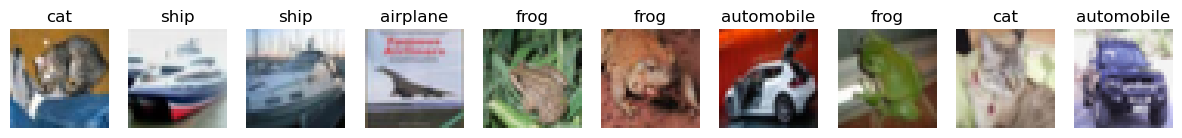

In [59]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# one hot encode target values
y_train_new = tf.keras.utils.to_categorical(y_train_new, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

classNames = ['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']

fig, ax = plt.subplots(1, 10, figsize=(15,2))
for i in range(10):
    ax[i].axis('off')
    cls_idx = np.argmax(y_test[i])
    ax[i].set_title(classNames[cls_idx])
    ax[i].imshow(X_test[i])
plt.show()


# Step : Normalize the data

In [60]:
# Convert to float32
X_train_new = X_train_new.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Normalize pixel values to [0, 1]
X_train_norm = X_train_new / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

# Show shapes
print("Training set shape:", X_train_norm.shape)
print("Validation set shape:", X_val_norm.shape)
print("Test set shape:", X_test_norm.shape)


print(y_train_new.shape, y_val.shape, y_test.shape)
print(y_train_new[0])
print(y_val[0])
print(y_test[0])

Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
(40000, 10) (10000, 10) (10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


# Step : Define model

In [61]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

L2 = 1e-4
wreg = tf.keras.regularizers.l2(L2)

model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(64, 3, padding="same", activation=None,
                           kernel_initializer='he_uniform', kernel_regularizer=wreg,
                           use_bias=False, input_shape=[32,32,3]),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation=None,
                           kernel_initializer='he_uniform', kernel_regularizer=wreg,
                           use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation=None,
                           kernel_initializer='he_uniform', kernel_regularizer=wreg,
                           use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(2), tf.keras.layers.SpatialDropout2D(0.10),

    # Block 2
    tf.keras.layers.Conv2D(128, 3, padding="same", activation=None,
                           kernel_initializer='he_uniform', kernel_regularizer=wreg,
                           use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation=None,
                           kernel_initializer='he_uniform', kernel_regularizer=wreg,
                           use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation=None,
                           kernel_initializer='he_uniform', kernel_regularizer=wreg,
                           use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(2), tf.keras.layers.SpatialDropout2D(0.15),

    # Block 3
    tf.keras.layers.Conv2D(256, 3, padding="same", activation=None,
                           kernel_initializer='he_uniform', kernel_regularizer=wreg,
                           use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256, 3, padding="same", activation=None,
                           kernel_initializer='he_uniform', kernel_regularizer=wreg,
                           use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256, 3, padding="same", activation=None,
                           kernel_initializer='he_uniform', kernel_regularizer=wreg,
                           use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(2), tf.keras.layers.SpatialDropout2D(0.20),

    # Head
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation=None, kernel_regularizer=wreg, use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax', dtype='float32')
])

model.summary()

/Users/homer/_mygit/cas-aml/_Miniforge/install_dir/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_12            │ (None, 16, 16, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,993,162 (7.60 MB)

 Trainable params: 1,989,962 (7.59 MB)

 Non-trainable params: 3,200 (12.50 KB)

# Step : Use augmentation

In [62]:
import tensorflow as tf

# --------------------------
# CutMix implementation
# --------------------------
def cutmix(images, labels, alpha=1.0):
    batch_size = tf.shape(images)[0]
    W = tf.shape(images)[1]
    H = tf.shape(images)[2]

    labels = tf.cast(labels, tf.float32)

    lam = tf.random.gamma([], alpha, 1.0)
    lam = lam / (lam + tf.random.gamma([], alpha, 1.0))
    lam = tf.cast(lam, tf.float32)

    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)

    rx = tf.random.uniform([], 0, W, dtype=tf.int32)
    ry = tf.random.uniform([], 0, H, dtype=tf.int32)
    rw = tf.cast(tf.cast(W, tf.float32) * tf.math.sqrt(1. - lam), tf.int32)
    rh = tf.cast(tf.cast(H, tf.float32) * tf.math.sqrt(1. - lam), tf.int32)

    x1 = tf.clip_by_value(rx - rw // 2, 0, W)
    y1 = tf.clip_by_value(ry - rh // 2, 0, H)
    x2 = tf.clip_by_value(rx + rw // 2, 0, W)
    y2 = tf.clip_by_value(ry + rh // 2, 0, H)

    mask = tf.pad(tf.ones((y2 - y1, x2 - x1, 3), dtype=tf.float32),
                  [[y1, H - y2], [x1, W - x2], [0, 0]])

    images = tf.cast(images, tf.float32)
    shuffled_images = tf.cast(shuffled_images, tf.float32)

    images = images * (1 - mask) + shuffled_images * mask
    lam = 1 - tf.cast((x2 - x1) * (y2 - y1), tf.float32) / tf.cast((W * H), tf.float32)
    labels = lam * labels + (1 - lam) * shuffled_labels
    return images, labels


# --------------------------
# MixUp implementation
# --------------------------
def mixup(images, labels, alpha=1.0):
    batch_size = tf.shape(images)[0]
    labels = tf.cast(labels, tf.float32)

    lam = tf.random.gamma([], alpha, 1.0)
    lam = lam / (lam + tf.random.gamma([], alpha, 1.0))
    lam = tf.cast(lam, tf.float32)

    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)

    images = tf.cast(images, tf.float32)
    shuffled_images = tf.cast(shuffled_images, tf.float32)

    images = lam * images + (1 - lam) * shuffled_images
    labels = lam * labels + (1 - lam) * shuffled_labels
    return images, labels


# --------------------------
# Simple augmentation (flip, translate)
# --------------------------
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])


# --------------------------
# Unified augmentation pipeline
# --------------------------
def augment_pipeline(images, labels, alpha=1.0):
    choice = tf.random.uniform([], 0, 1)

    images = tf.cast(images, tf.float32)
    labels = tf.cast(labels, tf.float32)

    return tf.case([
        (tf.less(choice, 1/3), lambda: cutmix(images, labels, alpha)),
        (tf.less(choice, 2/3), lambda: mixup(images, labels, alpha))
    ], default=lambda: (tf.cast(augment(images, training=True), tf.float32), labels))


# --------------------------
# Preprocessing
# --------------------------
def preprocess_train(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

def preprocess_val(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y


# --------------------------
# Datasets
# --------------------------
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x, y: augment_pipeline(x, y, alpha=1.0),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)
          .prefetch(tf.data.AUTOTUNE))


# Step : Run the model with augmented dataset

In [63]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(loss=loss,
              optimizer=opt, 
              metrics=['accuracy'])

In [64]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-9
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5", monitor="val_loss",
    save_best_only=True, save_weights_only=True, verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=25, restore_best_weights=True, verbose=1
)


# Step : Train the model

In [65]:
history = model.fit(
    train_ds, 
    epochs=500, 
    validation_data=val_ds,
    callbacks = [lr_scheduler, checkpoint_cb, earlystop_cb],
    verbose=1    
    )

Epoch 1/500
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2225 - loss: 2.5676
Epoch 1: val_loss improved from None to 1.89700, saving model to best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2802 - loss: 2.3779 - val_accuracy: 0.4481 - val_loss: 1.8970 - learning_rate: 0.0100
Epoch 2/500
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3762 - loss: 2.1683
Epoch 2: val_loss improved from 1.89700 to 1.75498, saving model to best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.3967 - loss: 2.1271 - val_accuracy: 0.5069 - val_loss: 1.7550 - learning_rate: 0.0100
Epoch 3/500
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4362 - loss: 2.0538
Epoch 3: val_loss improved from 1.75498 to 1.58281, saving model to best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.4535 - loss: 2.0203 - val_accuracy: 0.5949 - val_loss: 1.5828 - learning_rate: 0.0100
Epoch 4/500
625/625 ━━━━━━━━━━━━━━━━━━━━

# Step : Visualyze and evaluate model

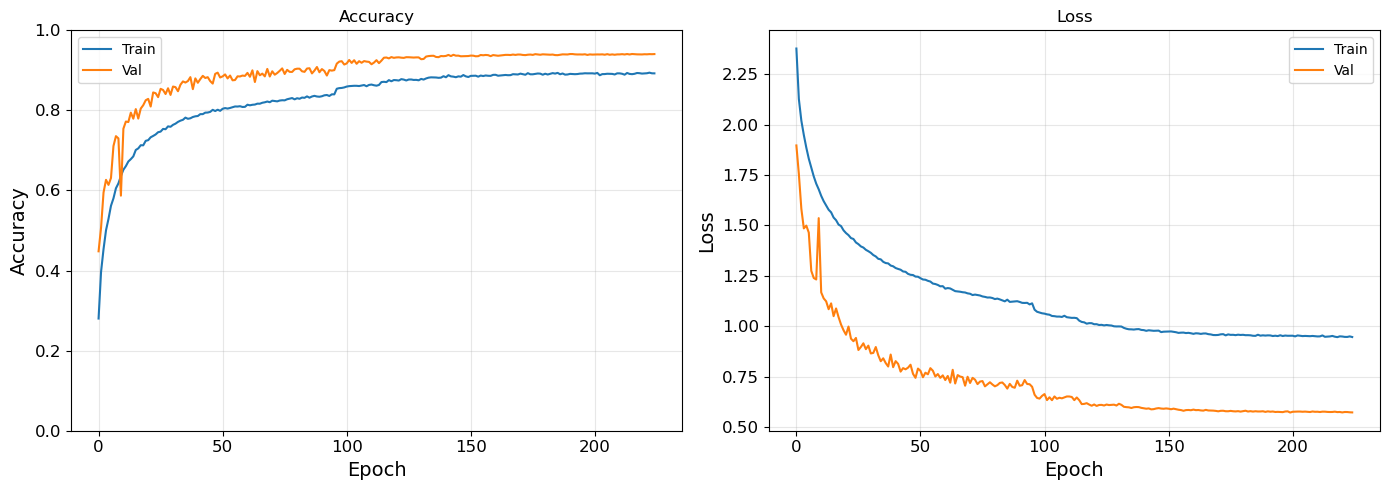

In [69]:
# Create subplots for Accuracy and Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot Loss
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.9381


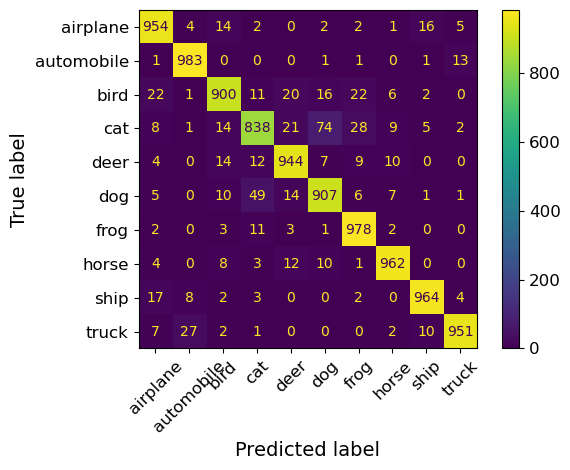

              precision    recall  f1-score   support

    airplane       0.93      0.95      0.94      1000
  automobile       0.96      0.98      0.97      1000
        bird       0.93      0.90      0.92      1000
         cat       0.90      0.84      0.87      1000
        deer       0.93      0.94      0.94      1000
         dog       0.89      0.91      0.90      1000
        frog       0.93      0.98      0.95      1000
       horse       0.96      0.96      0.96      1000
        ship       0.96      0.96      0.96      1000
       truck       0.97      0.95      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test_loss, test_acc = model.evaluate(X_test_norm, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Get predictions
y_prob = model.predict(X_test_norm, batch_size=256, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Convert one-hot encoded y_test to class indices
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classNames)
disp.plot(xticks_rotation=45)
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=classNames))

# Step : Save model


In [68]:
model.save("cifar10_cutmix_mixup_model_2.keras")
